# Range UC

## Functions

In [4]:
# Get SA indices measured by range increase
def calculate_SA_indices_increase(ds, year_groups):
    # For results
    ds_out = []

    for year_group in year_groups:
        # Take time slice
        yr_start, yr_end = year_group
        ds_sel = ds.sel(time=slice(yr_start, yr_end))

        # Calculate range changes
        all_dims = ['projection_id', 'obs_name', 'loss_metric', 'time']
        full_range = (ds_sel[soil_metric].max(dim=all_dims) - ds_sel[soil_metric].min(dim=all_dims))

        # Percentage increase due to products
        obs_range = ds_sel[soil_metric].max(dim=['projection_id', 'loss_metric', 'time']) - ds_sel[soil_metric].min(dim=['projection_id', 'loss_metric', 'time'])
        prod_increase = 100*((full_range / obs_range) - 1.).mean(dim="obs_name")
        
        # Percentage increase due to loss functions
        rmse_range = ds_sel[soil_metric].sel(loss_metric = 'rmse').max(dim=['projection_id', 'time']) - ds_sel[soil_metric].sel(loss_metric = 'rmse').min(dim=['projection_id', 'time'])
        loss_increase = 100*((obs_range / rmse_range) - 1.).mean(dim="obs_name")

        # Percentage increase due to both
        combined_increase = 100*((full_range / rmse_range) - 1.).mean(dim="obs_name")
        
        # Merge
        ds_tmp = xr.merge([xr.Dataset({'product':prod_increase}),
                           xr.Dataset({'loss':loss_increase}),
                          xr.Dataset({'combined':combined_increase})])
        ds_tmp = ds_tmp.assign_coords(time=yr_end)
        ds_out.append(ds_tmp)

    # Concat along time
    ds_out = xr.concat(ds_out, dim="time")
    return ds_out.compute()

In [5]:
# Plot range increases for single gridpoint
def plot_ranges_single(df, year_group, soil_metric, ax, ylabels, xlabel, legend, title, colors, lw):
    # Select data
    df_sel = df[(df['time'] >= year_group[0]) & (df['time'] <= year_group[1])]
        
    # Plot full range
    min, max = df_sel[soil_metric].min(), df_sel[soil_metric].max()
    # min, max = np.quantile(df_sel[soil_metric], 0.005), np.quantile(df_sel[soil_metric], 0.995)
    ax.hlines(y=0, xmin=min, xmax=max, color='black', lw=2)
    ax.scatter([max], [0], marker='>', color='black')
    ax.scatter([min], [0], marker='<', color='black')
    
    # Loop through obs
    for ido, obs_name in enumerate(obs_names):
        # Where to plot
        idloc = 1 + ido
        # RMSE only
        data_rmse = df_sel[(df_sel['loss_metric'] == "rmse") & (df_sel['obs_name'] == obs_name)][soil_metric]
        min, max = data_rmse.min(), data_rmse.max()
        # min, max = np.quantile(data_rmse, 0.005), np.quantile(data_rmse, 0.995)
        # mean = data_rmse.mean()
        ax.hlines(y=idloc, xmin=min, xmax=max, color=colors[obs_name], lw=2)
        ax.scatter([min, max], [idloc,idloc], marker='o', color=colors[obs_name])
        ax.scatter([min, max], [idloc,idloc], marker='o', color=colors[obs_name])
        # ax.scatter([mean], [ido], marker='|', color='black')

        # All
        data_all = df_sel[(df_sel['obs_name'] == obs_name)][soil_metric]
        min, max = data_all.min(), data_all.max()
        # min, max = np.quantile(data_all, 0.005), np.quantile(data_all, 0.995)
        # mean = data_all.mean()
        ax.hlines(y=idloc, xmin=min, xmax=max, color=colors[obs_name], ls='--', lw=2)
        ax.scatter([max], [idloc], marker='>', color=colors[obs_name])
        ax.scatter([min], [idloc], marker='<', color=colors[obs_name])
        # ax.scatter([mean], [ido], marker='|', color='black')

    # Tidy
    ax.set_ylim([-0.5,4.5])
    if ylabels:
        ax.set_yticks(ticks=np.arange(5), labels = ['All'] + obs_names)
    else:
        ax.set_yticks(ticks=np.arange(5), labels=['','','',''])
    ax.grid(alpha=0.8)
    ax.set_axisbelow(True)

    # Add legend
    if legend:
        ax.legend([Line2D([0], [0], color='black', lw=2, ls='--'),
                      Line2D([0], [0], color='black', lw=2, ls='-')],
                     ['RMSE', 'All'],
                     loc=legend)

    # Axis label
    ax.set_xlabel(xlabel)
    ax.set_title(title)

In [90]:
def plot_increases(df, year_group, ax, soil_metric, colors, xlabel):
    # Select data
    df_sel = df[(df['time'] >= year_group[0]) & (df['time'] <= year_group[1])]
    
    # Calculate range changes
    all_dims = ['projection_id', 'obs_name', 'loss_metric', 'time']
    full_range = df_sel[soil_metric].max() - df_sel[soil_metric].min()

    # Percentage increase due to products
    obs_range = df_sel.groupby('obs_name')[soil_metric].max() - df_sel.groupby('obs_name')[soil_metric].min()
    prod_increase = 100*((full_range / obs_range) - 1.).mean()
        
    # Percentage increase due to loss functions
    df_rmse = df_sel[df_sel['loss_metric'] == 'rmse']
    rmse_range = df_rmse.groupby('obs_name')[soil_metric].max() - df_rmse.groupby('obs_name')[soil_metric].min()
    loss_increase = 100*((obs_range / rmse_range) - 1.).mean()

    # Percentage increase due to both
    obs_rmse_range = df_rmse.groupby('obs_name')[soil_metric].max() - df_rmse.groupby('obs_name')[soil_metric].min()
    full_increase = 100*((full_range / obs_rmse_range) - 1.).mean()

    # Plot means
    # y1, y2, y3 = 0.25, 0.5, 0.75
    # ax.barh(y1, full_increase, align='center', height=0.15, color='black')

    y1, y2 = 0.25, 0.75
    ax.barh(y1, prod_increase, align='center', height=0.15, color='black')
    ax.barh(y2, loss_increase, align='center', height=0.15, color='black')

    # Plot scatters
    for obs_name in obs_names:
        # ax.scatter(y=0.25, x=(100*((full_range / obs_rmse_range) - 1.))[obs_name], color=colors[obs_name])
        
        ax.scatter(y=0.25, x=(100*((full_range / obs_range) - 1.))[obs_name], color=colors[obs_name])
        ax.scatter(y=0.75, x=(100*((obs_range / rmse_range) - 1.))[obs_name], color=colors[obs_name])

    # Tidy
    ax.set_ylim([0,1])
    ax.grid(alpha=0.8)
    ax.set_axisbelow(True)
    # ax.set_yticks([y1,y2,y3], ['Combined', 'Additional products', 'Additional loss functions'])
    ax.set_yticks([y1,y2], ['Additional products', 'Additional loss functions'])
    if xlabel:
        ax.set_xlabel('Increase in uncertainty (%)')

In [8]:
"""
Uncertainty sources gridpoint
"""
def gridpoint_plot_soil_uc(df, soil_metrics, ssp, year_group, title, save_name):
    
    fig, axs = plt.subplots(2,3, figsize=(14,5), sharey='row', height_ratios=[3,1], gridspec_kw=dict(hspace=0.5))

    fig.suptitle(f'{title}; {ssp} ({year_group[0]}-{year_group[1]})', fontweight='bold', y=1.04)

    # Plot all
    for id, soil_metric in enumerate(soil_metrics):
        # LOC 1
        # Plot ranges
        plot_ranges_single(df=df, 
                       ax=axs[0,id],
                       soil_metric=soil_metric,
                       ylabels=True,
                       xlabel="[mm]",
                       title = soil_labels[id],
                       legend=False,
                       year_group=year_group,
                       colors=obs_colors,
                       lw=2)
        # Plot changes
        plot_increases(df=df,
                   ax=axs[1,id],
                   soil_metric=soil_metric,
                   year_group=year_group,
                   colors=obs_colors,
                   xlabel=True)

    if save_name:
        plt.savefig(f'../figs/{save_name}.pdf', bbox_inches='tight')
    else:
        plt.show()

In [9]:
"""
Uncertainty sources map
"""
def map_plot_soil_uc(ds, soil_metrics, ssp, year_group, save_name, vmax = 200., cmap = sc_cmap):
    # Otherwise breaks
    assert len(soil_metrics) == 3

    # Select time
    ds_sel = ds.sel(time=year_group[1])
    
    fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True,
                       gridspec_kw=dict(wspace=0.1, hspace=0.01),
                       subplot_kw=dict(projection=ccrs.LambertConformal()))

    for idx, soil_metric in enumerate(soil_metrics):
        # Loss function
        ax=axs[0,idx]
        p = ds_sel.sel(soil_metric=soil_metric)['loss'].plot(ax=ax, vmin=0., vmax=vmax, 
                                               levels=11, cmap=cmap,
                                               add_colorbar=False, transform=ccrs.PlateCarree())
        # Product
        ax=axs[1,idx]
        p = ds_sel.sel(soil_metric=soil_metric)['product'].plot(ax=ax, vmin=0., vmax=vmax, 
                                                   levels=11, cmap=cmap,
                                                   add_colorbar=False, transform=ccrs.PlateCarree())
    
        # # Combined
        # ax=axs[2,idx]
        # p = ds_sel.sel(soil_metric=soil_metric)['combined'].plot(ax=ax, vmin=0., vmax=vmax, 
        #                                        levels=11, cmap=cmap,
        #                                        add_colorbar=False, transform=ccrs.PlateCarree())
    
    # Tidy
    for ax in axs.flatten():
        ax.coastlines()
        gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
        ax.set_title('')

    # Coords for some
    gl = axs[1,2].gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
    gl.top_labels = False
    gl.left_labels = False
    
    for ax in [axs[1,0], axs[1,1]]:
        gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = False
    
    for ax in [axs[0,2], axs[1,2]]:
        gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
        gl.top_labels = False
        gl.bottom_labels = False
        gl.left_labels = False
    
    # Titles
    axs[0,0].set_title(soil_labels[0])
    axs[0,1].set_title(soil_labels[1])
    axs[0,2].set_title(soil_labels[2])
    fig.suptitle(f'{year_group[0]}-{year_group[1]} under {ssp}', fontweight='bold', y=0.94)
    
    # Label
    axs[0,0].text(-0.05, 0.5, 'Loss Functions', horizontalalignment='center', fontsize=14,
                  rotation=90, verticalalignment='center', transform=axs[0,0].transAxes)
    
    axs[1,0].text(-0.05, 0.5, 'Products', horizontalalignment='center', fontsize=14,
                  rotation=90, verticalalignment='center', transform=axs[1,0].transAxes)
    
    # axs[2,0].text(-0.05, 0.5, 'Combined', horizontalalignment='center', fontsize=14,
    #               rotation=90, verticalalignment='center', transform=axs[2,0].transAxes)
    
    # Cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Average Increase in Uncertainty (%)",
                 ax=axs, pad=0.06, shrink=0.5)
    
    if save_name:
        plt.savefig(f'../figs/{save_name}.png', dpi=600, bbox_inches='tight')
    else:
        plt.show()

In [10]:
# def plot_ranges_time(df, ax, ylabels, xlabel, legend):
#     # For time evolution
#     colors = ["#b3cde3", "#8c96c6", "#88419d"]
#     for idt, year_group in enumerate(year_groups):
#         # Select data
#         df_sel = df[(df['time'] >= year_group[0]) & (df['time'] <= year_group[1])]
        
#         # Plot full range
#         min, max = df_sel[soil_metric].min(), df_sel[soil_metric].max()
#         ax.hlines(y=-idt/4, xmin=min, xmax=max, color=colors[idt])
#         ax.scatter([max], [-idt/4], marker='>', color=colors[idt])
#         ax.scatter([min], [-idt/4], marker='<', color=colors[idt])
        
#         # Loop through obs
#         for ido, obs_name in enumerate(obs_names):
#             # Where to plot
#             idloc = 1 + ido - (idt/4)
#             # RMSE only
#             data_rmse = df_sel[(df_sel['loss_metric'] == "rmse") & (df_sel['obs_name'] == obs_name)][soil_metric]
#             min, max = data_rmse.min(), data_rmse.max()
#             # mean = data_rmse.mean()
#             ax.hlines(y=idloc, xmin=min, xmax=max, color=colors[idt])
#             ax.scatter([min, max], [idloc,idloc], marker='o', color=colors[idt])
#             ax.scatter([min, max], [idloc,idloc], marker='o', color=colors[idt])
#             # ax.scatter([mean], [ido], marker='|', color='black')
    
#             # All
#             data_all = df_sel[(df_sel['obs_name'] == obs_name)][soil_metric]
#             min, max = data_all.min(), data_all.max()
#             # mean = data_all.mean()
#             ax.hlines(y=idloc, xmin=min, xmax=max, color=colors[idt], ls='--')
#             ax.scatter([max], [idloc], marker='>', color=colors[idt])
#             ax.scatter([min], [idloc], marker='<', color=colors[idt])
#             # ax.scatter([mean], [ido], marker='|', color='black')
    
#         # Tidy
#         if ylabels:
#             ax.set_yticks(ticks=np.arange(5)-0.25, labels = ['All'] + obs_names)
#         else:
#             ax.set_yticks(ticks=np.arange(5)-0.25, labels=['','','',''])
#         ax.grid(alpha=0.8)

#     # Add legend to one
#     if legend:
#         ax.legend([Line2D([0], [0], color='black', lw=2, ls='--'),
#                       Line2D([0], [0], color='black', lw=2, ls='-')],
#                      ['RMSE', 'All'],
#                      loc=legend)

#     # Axis label
#     ax.set_xlabel(xlabel)


# # For time evolution
# colors = ["#b3cde3", "#8c96c6", "#88419d"]
# colors = ['C0']

# fig, axs = plt.subplots(1,2, figsize=(8,5), sharey=True)

# # NE
# ax=axs[0]
# plot_ranges_time(df=df_ne, 
#             ax=ax,
#             ylabels=True,
#             xlabel='Annual Average Soil Moisture [mm]',
#             legend=False)

# # KY
# ax=axs[1]
# plot_ranges_time(df=df_ky, 
#             ax=ax,
#             ylabels=True,
#             xlabel='Annual Average Soil Moisture [mm]',
#             legend='upper right')

# plt.show()

In [15]:
# Select SSP and years
# ssp = 'SSP2-4.5'
ssp = 'SSP3-7.0'
ssp_read = [ssp.lower().replace('.','').replace('-','')]

In [55]:
%%time
# Get all soil metrics
ds_out = []
for soil_metric in soil_metrics:
    ds_all = read_all(subset_name, soil_metric, ssp_read)
    ds_sa = calculate_SA_indices(ds_all, year_groups)
    ds_sa = ds_sa.assign_coords(soil_metric = soil_metric)
    ds_out.append(ds_sa)

# Combine
ds_out = xr.concat(ds_out, dim='soil_metric')

CPU times: user 1min 32s, sys: 12.6 s, total: 1min 45s
Wall time: 2min 23s


## Plots

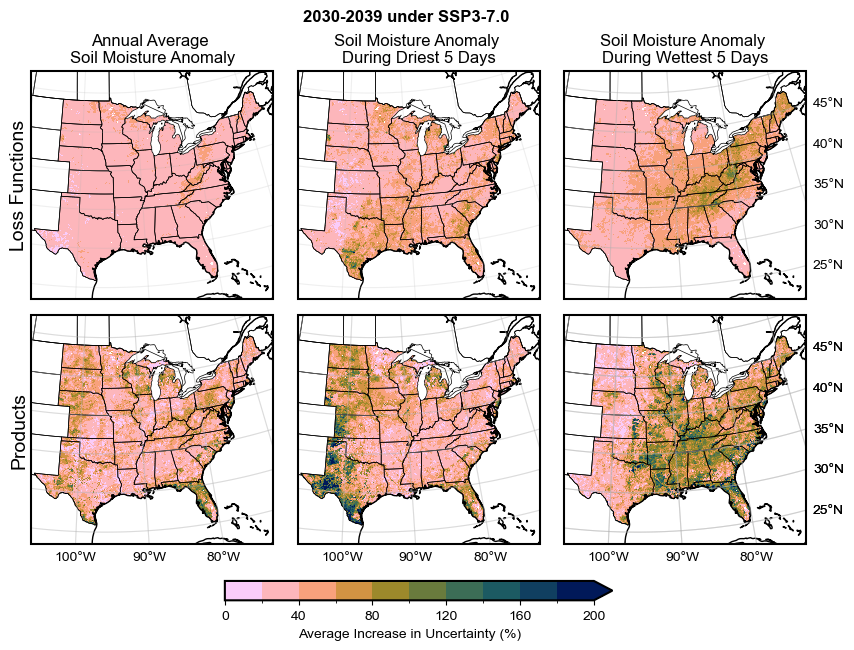

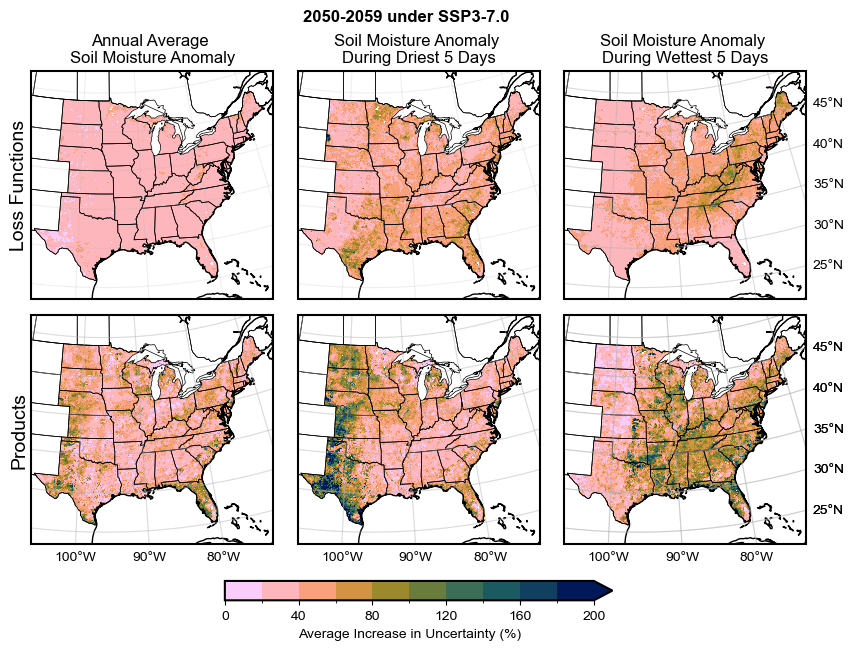

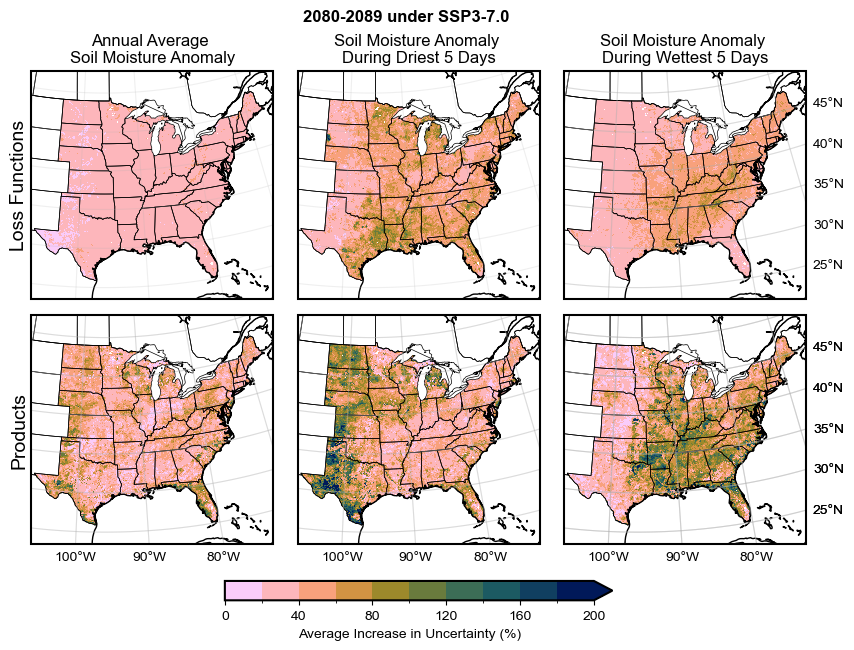

In [56]:
"""
Uncertainty sources map
"""
for year_group in year_groups:
    map_plot_soil_uc(ds_out, soil_metrics, ssp, year_group,
                     save_name=f'map_soil_sa_{ssp_read[0]}_{year_group[0]}-{year_group[1]}')

## Range plots

In [13]:
# Select SSP
# ssp = 'SSP2-4.5'
ssp = 'SSP3-7.0'

ssp_read = [ssp.lower().replace('.','').replace('-','')]

In [15]:
%%time
##### Get all soil metrics
# McLean County IL
lat1, lon1 = 40.61752192312278, -88.68366477345201

df_out_loc1 = []

for soil_metric in soil_metrics:
    # Read all 
    ds_all = read_all(subset_name, soil_metric, ssp_read)

    # Get locs
    df_loc1 = ds_all.sel(lat=lat1, lon=lon1, method="nearest")
    df_loc1 = df_loc1[soil_metric].to_dataframe().reset_index()
    df_out_loc1.append(df_loc1)

# Merge all
df_out_loc1 = reduce(lambda x,y: pd.merge(x,y), df_out_loc1)

CPU times: user 53.8 s, sys: 14 s, total: 1min 7s
Wall time: 2min 5s


In [17]:
soil_labels = ["a) Annual Average \nSoil Moisture Anomaly", 
               "b) Soil Moisture Anomaly \nDuring Driest 5 Days",
               "c) Soil Moisture Anomaly \nDuring Wettest 5 Days"]

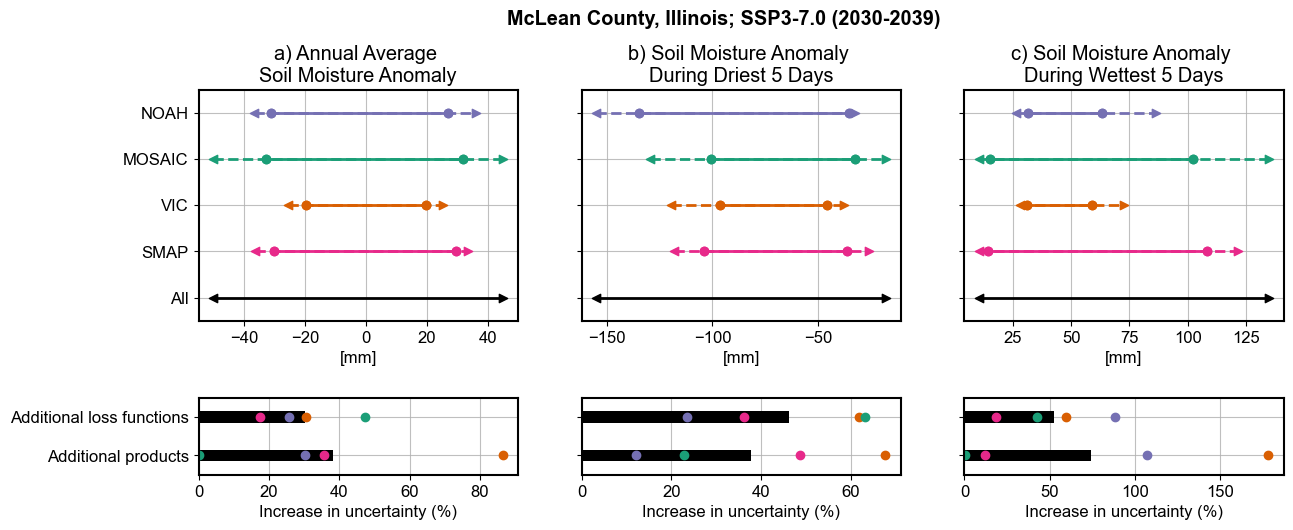

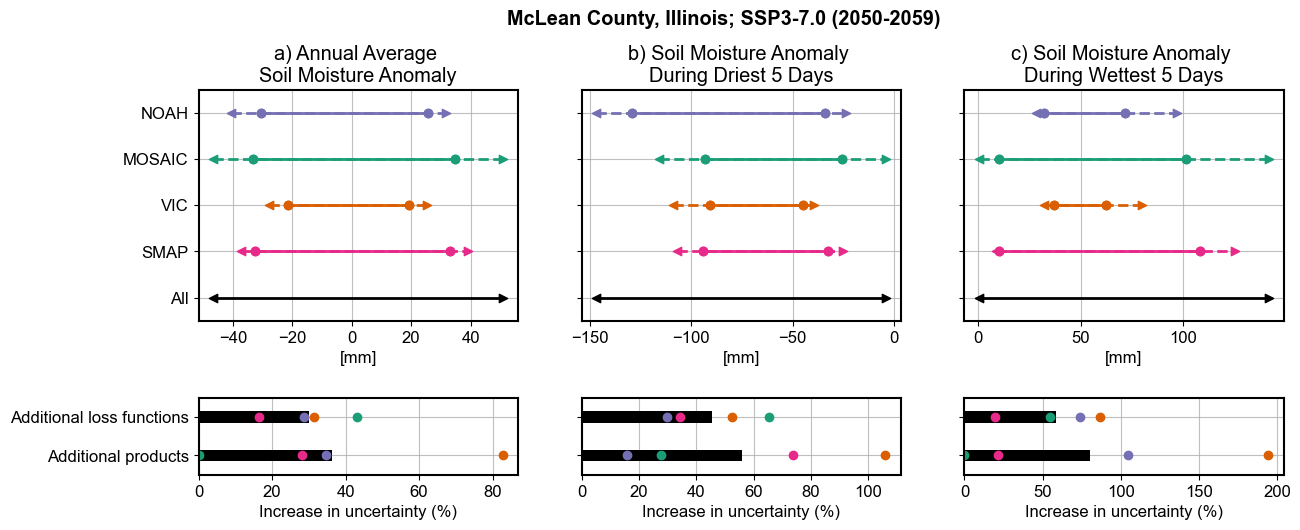

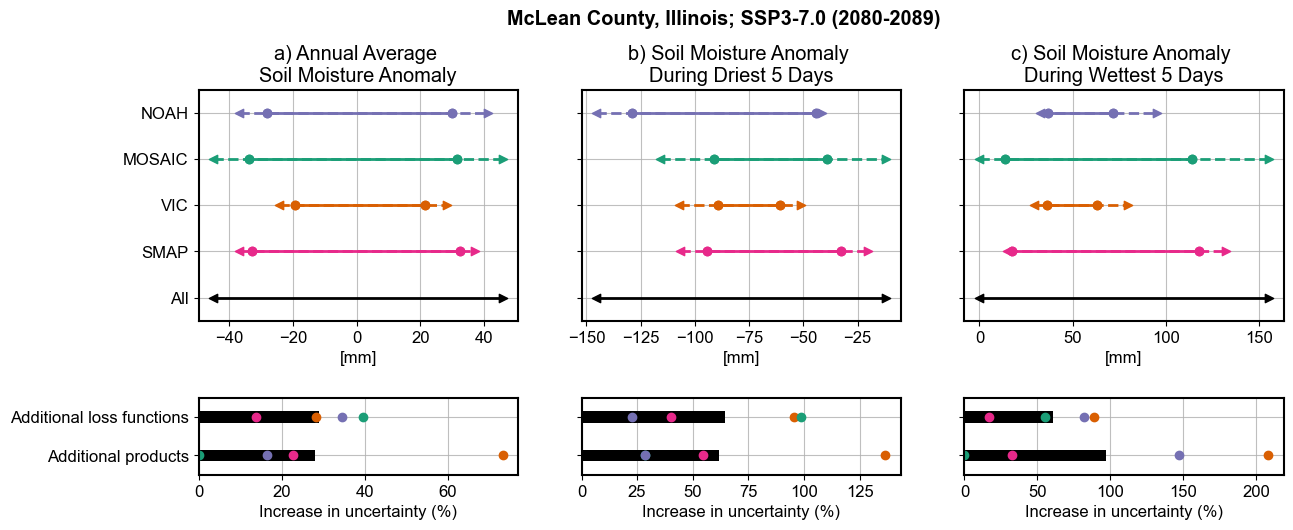

In [18]:
# Plot
title = "McLean County, Illinois"

for year_group in year_groups:
    gridpoint_plot_soil_uc(df_out_loc1, soil_metrics, ssp, year_group, title,
                           save_name=f'il_param_increase_{ssp_read[0]}_{year_group[0]}-{year_group[1]}')

## Old

In [172]:
%%time
##### Get all soil metrics
# West Texas
lat1, lon1 = 31.31305803607532, -102.2111532257517
# West Central Kentucky
lat2, lon2 = 37.33650616215579, -86.51181594341504

df_out_loc1 = []
df_out_loc2 = []

for soil_metric in ['mean', '5dmin', '5dmax']:
    # Read all 
    ds_all = read_all(subset_name, soil_metric, ssps, n_member_min, loss_metrics_drop)

    # Get locs
    df_loc1 = ds_all.sel(lat=lat1, lon=lon1, method="nearest")
    df_loc1 = df_loc1[soil_metric].to_dataframe().reset_index()
    df_out_loc1.append(df_loc1)
    
    df_loc2 = ds_all.sel(lat=lat2, lon=lon2, method="nearest")
    df_loc2 = df_loc2[soil_metric].to_dataframe().reset_index()
    df_out_loc2.append(df_loc2)

# Merge all
df_out_loc1 = reduce(lambda x,y: pd.merge(x,y), df_out_loc1)
df_out_loc2 = reduce(lambda x,y: pd.merge(x,y), df_out_loc2)

CPU times: user 1min 11s, sys: 9.04 s, total: 1min 20s
Wall time: 2min 34s


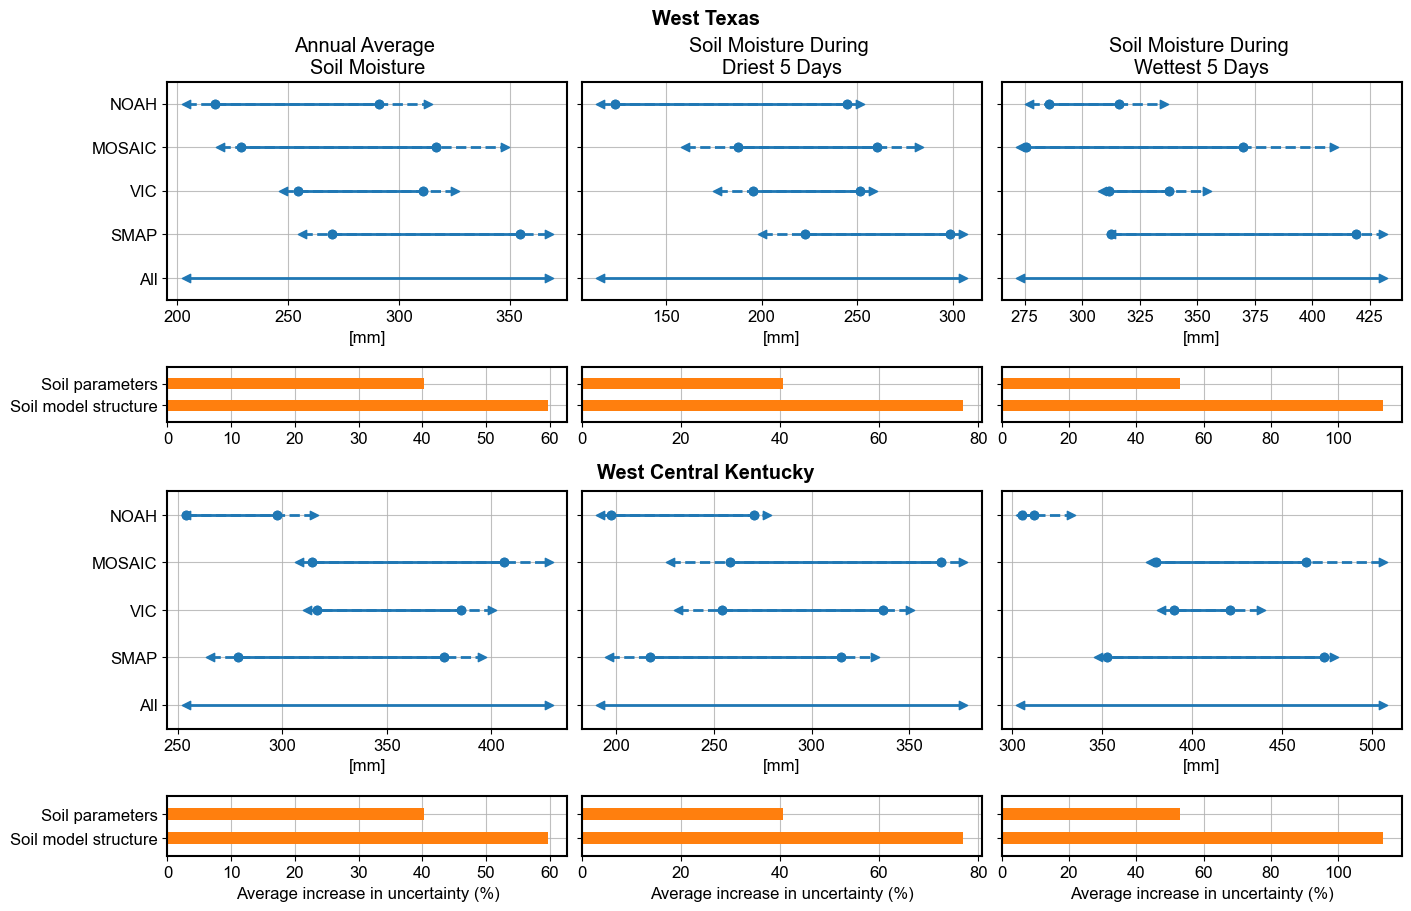

In [217]:
color_dist = "C0"
color_diff = "C1"
lw = 2

fig = plt.figure(layout='constrained', figsize=(14, 9))
subfigs = fig.subfigures(2, 1, wspace=0.15)

subfigs[0].suptitle('West Texas', fontweight='bold')
axsTop = subfigs[0].subplots(2,3, sharey='row', height_ratios=[4,1], gridspec_kw=dict(hspace=0.05))

subfigs[1].suptitle('West Central Kentucky', fontweight='bold')
axsBottom = subfigs[1].subplots(2,3, sharey='row', height_ratios=[4,1], gridspec_kw=dict(hspace=0.05))

# Plot all
for id, soil_metric in enumerate(soil_metrics):
    # LOC 1
    # Plot ranges
    plot_ranges_single(df=df_out_loc1, 
                       ax=axsTop[0,id],
                       soil_metric=soil_metric,
                       ylabels=True,
                       xlabel="[mm]",
                       title = soil_labels[id],
                       legend=False,
                       year_group=year_groups[0],
                       color=color_dist, lw=2)
    # Plot changes
    plot_increases(df=df_out_loc1,
                   ax=axsTop[1,id],
                   soil_metric=soil_metric,
                   color=color_diff,
                   xlabel=False)

    # LOC 2
    # Plot ranges
    plot_ranges_single(df=df_out_loc2, 
                       ax=axsBottom[0,id],
                       soil_metric=soil_metric,
                       ylabels=True,
                       xlabel="[mm]",
                       title = "",
                       legend=False,
                       year_group=year_groups[0],
                       color=color_dist, lw=2)
    # Plot changes
    plot_increases(df=df_out_loc1,
                   ax=axsBottom[1,id],
                   soil_metric=soil_metric,
                   color=color_diff,
                   xlabel=True)

plt.show()